In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from tqdm import tqdm
from scipy.signal import find_peaks

# Structure of notebook


 Question 1 
-------------------------
 Question 2 
-------------------------
 Question 3 
 -------------------------
     (this is just code plus some comments on the code)

     ** Initial parameters/ Data process
     -------------------------
     ** Functions 
     -------------------------
     ** Code execution/ loops
     -------------------------
Question 4 
-------------------------
     ** Results/Comments 
     -------------------------


# 1. Question: Gaussian Case


The Gaussian model is given by:
$d_i = \sum_{j=1}^{q} \frac{A_j}{\sqrt{2\pi}c_j} \exp\left[-\frac{(z_i - f_j)^2}{2c_j^2}\right]$

1. Partial derivative with respect to \( A_p \):

$
\frac{\partial g_i}{\partial A_p} = \frac{1}{\sqrt{2\pi}c_p} \exp\left[-\frac{(z_i - f_p)^2}{2c_p^2}\right]
$

2. Partial derivative with respect to \( f_p \):

$
\frac{\partial g_i}{\partial f_p} = \frac{A_p(z_i - f_p)}{\sqrt{2\pi}c_p^3} \exp\left[-\frac{(z_i - f_p)^2}{2c_p^2}\right]
$

3. Partial derivative with respect to \( c_p \):

$
\frac{\partial g_i}{\partial c_p} = \frac{A_p(z_i - f_p)^2}{\sqrt{2\pi}c_p^4} \exp\left[-\frac{(z_i - f_p)^2}{2c_p^2}\right]
$


# 2. Question: Lorentzian Case


The Lorentzian model is given by:

$
d_i = \sum_{j=1}^{q} \frac{A_j c_j^2}{(z_i - f_j)^2 + c_j^2}
$
1. Partial derivative with respect to \( A_p \):

$
\frac{\partial g_i}{\partial A_p} = \frac{c_p^2}{(z_i - f_p)^2 + c_p^2}
$

2. Partial derivative with respect to \( f_p \):

$
\frac{\partial g_i}{\partial f_p} = -\frac{2A_p(z_i - f_p)}{(z_i - f_p)^2 + c_p^2}
$

3. Partial derivative with respect to \( c_p \):

$
\frac{\partial g_i}{\partial c_p} = \frac{2A_p c_p (z_i - f_p)^2}{((z_i - f_p)^2 + c_p^2)^2}
$


# 3. Question

---------------------------------------------------

In [2]:
path = 'mars_soil.txt'
data = np.loadtxt(path)
np.shape(data) 

(512, 2)

The data are not so easy to work on the way they are, so I will flip them upside down and bring the "base" to zero

In [3]:
# offset
offset = data[0,1]              # add offset, so it's easier to fit later
print('offset:', offset)

# data
z = data[:,0]                        # Velocity, mm/s
ydata = -1*(data[:,1] - offset)      # Observed Data [counts]: add offset and flip
sigma_d = 0.03 * 10**4              # Uncertainty, observed data


offset: 12623.0


# Functions

In [4]:
def gaussian(z, A, f, c):
    '''
    This function adds up the peaks that are considered to be Gaussian
    '''
    
    pi = np.pi  
    gauss = np.zeros(len(z))    
    for i in range(len(A)):
        gauss += (A[i]/(np.sqrt(2*pi)*c[i])) * np.exp(-(z-f[i])**2 / (2*c[i]**2))   
    return gauss

def lorentzian(z, A, f, c):
    '''
    This function adds up the peaks that are considered to be lorentzian
    '''
    lorentz = np.zeros(len(z)) 

    for i in range(len(A)):
        lorentz += A[i]*c[i]**2/((z-f[i])**2 + c[i]**2)
    
    return lorentz 
    
    

In [5]:
def calc_g(M_, z_, gauss=True):
    '''
    Here we evaluate g_k(m_k) by looping over the number of peaks
    
    returns a 1 x 512 array
    '''
    z, M = z_.copy(), M_.copy()    
    l = int(len(M)/3)             
    A, f, c = unpack(M)         
    
    pi = np.pi                      
    g = np.zeros(len(z))           

    for i in range(l):              
        if gauss:                        
            g += (A[i]/(np.sqrt(2*pi)*c[i])) * np.exp(-(z-f[i])**2 / (2*c[i]**2))   
        else:
            g += A[i]*c[i]**2/((z-f[i])**2 + c[i]**2)           

    return g       



In [6]:
def calc_Cd(data_, s_d):
    '''
    Correlation of data
    returns  a 512 x 512 array
    '''
    l = len(data_)             
    cov_d = np.eye(l) * s_d     
    return cov_d                


In order to test how much we are fitting on the data we have we re going ot use $\chi^{2}$

In [7]:
def chi_square(data, comp_data, s_d):
    chi_square = np.sum( (data - comp_data)/s_d)**2
    return chi_square

In [8]:
def prior(A, f, c):
    '''
    In this function I take all the parameters and combine into the prior parameters.
    '''
    M_prior = []
    for i in range(len(A)):
        M_prior.append(A[i])
        M_prior.append(f[i])
        M_prior.append(c[i])

    return np.array(M_prior)

def unpack(M):
    '''
    In this function I just unpack the prior into the parameters
    '''
    return M[0::3], M[1::3], M[2::3]   

In [9]:
def gaussian_derivatives(M, q, z):
    '''
    This function calculates the derivatives for the Gaussian function
    '''
    if q>19:    # in case
        print('Warning, q exceeds number of parameters in M')
    
    pi = np.pi
    A = M[q*3]          
    f = M[1+q*3]         
    c = M[2+q*3]

    diff_A = (1/(np.sqrt(2*pi)*c)) * np.exp(- (z-f)**2 / (2*c**2))                        
    diff_f = (A/(np.sqrt(2*pi)*c)) * ((z-f)/(c**2)) * np.exp(-(z-f)**2 / (2*c**2))  
    diff_c = -(A/(np.sqrt(2*pi)*c**2)) * np.exp(-(z-f)**2 /(2*c**2))  +  (A/(np.sqrt(2*pi)*c**4)) * (z-f)**2 *np.exp(-(z-f)**2 / (2*c**2))  

    return diff_A, diff_f, diff_c

def lorentzian_derivatives(M, q, z):
    '''
    This function calculates the derivatives for the Lorentzian function
    '''
    A = M[0+q*3]   
    f = M[1+q*3]
    c = M[2+q*3]

    diff_A = c**2/((z-f)**2 + c**2)              
    diff_f = A*c**2/((z-f)**2 + c**2)**2 * 2 * (z-f)    
    diff_c = 2*A*c/((z-f)**2 + c**2) - 2*A*c**3/(((z-f)**2 + c**2)**2) 

    return diff_A, diff_f, diff_c   

In [10]:
def calc_G(M, z, gauss=True):
    
    l = len(M)                  # 60

    if gauss:                                          
        for i in range(int (l/3) ):                   
            diff = np.array(gaussian_derivatives(M, i, z))        
            if i == 0:
                G = diff
            else:
                G = np.vstack((G, diff))              
            
    else:                                              
        for i in range(int (l/3) ):
            diff = np.array(lorentzian_derivatives(M, i, z))      

            if i == 0:  
               G = diff
            else:
               G = np.vstack((G, diff))         

    G = G.T    
    return G


In [11]:
def calc_Cm(M_, gauss_, s_Ag, s_fg, s_cg, s_Al, s_fl, s_cl):       
    '''
    Evaluate model Covariance Matrix, C_m
    '''
    M = M_.copy()
    descr = unpack(M)               
    A, f, c = descr[0], descr[1], descr[2] 

    if gauss_:     
        sA = s_Ag*A    
        sf = np.abs(s_fg*f)
        sc = s_cg*c
    else:           # Lorentzian
        sA = s_Al*A
        sf = np.abs(s_fl*f)
        sc = s_cl*c
        
    C_m = np.zeros((60,60))       
    diag = []                     

    for i in range(len(A)):
        diag.append(sA[i]**2)
        diag.append(sf[i]**2)
        diag.append(sc[i]**2)

    np.fill_diagonal(C_m, diag)           
    return C_m




In [12]:
def calc_eps(C_m, G, C_d, g_m, d_obs, M_, M_prior_):
    '''
    Evaluate epsilon at each step
    '''
    M, M_prior = M_.copy(), M_prior_.copy()

    gamma = C_m @ G.T @ np.linalg.inv(C_d) @ (g_m - d_obs) + M - M_prior

    eps = (gamma.T @ np.linalg.inv(C_m) @ gamma) / (gamma.T @ (G.T @ np.linalg.inv(C_d) @ G + np.linalg.inv(C_m)) @ gamma)
    return eps



In [13]:
def update_m(M_, M_prior_, z, d_obs_, C_d, gauss_):
    M, M_prior, d_obs = M_.copy(), M_prior_.copy(), d_obs_.copy()   

    G = calc_G(M, z, gauss=gauss_)                    
    g = calc_g(M, z, gauss=gauss_)                     
    C_m = calc_Cm(M, gauss_,s_Ag, s_fg, s_cg, s_Al, s_fl, s_cl)                            
    eps = calc_eps(C_m, G, C_d, g, d_obs, M, M_prior)   
    
    M_new = M - eps*(C_m @ G.T @ np.linalg.inv(C_d) @ (g - d_obs) + (M - M_prior)) 
    return M_new, eps, M_new - M      



# Code execution

## finding the peaks

I will use the "find_peaks" function to estimate the height of the gaussians

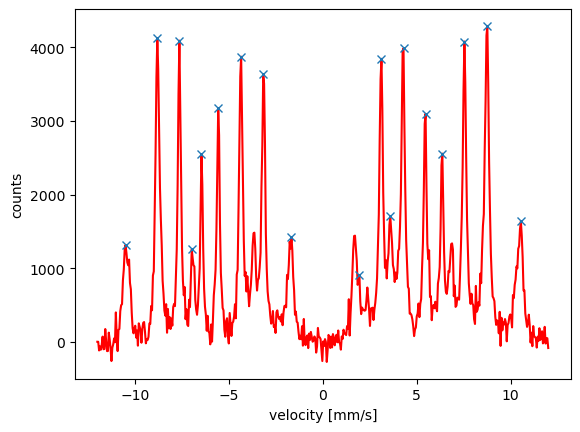

In [14]:
peaks, _ = find_peaks(ydata, height=900,threshold=30, distance=10)
y_peaks =  z[peaks]
x_peaks = peaks

## Plot data
plt.plot(z, ydata, 'r', label='data')   # plot of data
# amplitude plot: Ampl.

plt.plot(z[peaks], ydata[peaks], "x")

plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.show()

In [15]:
ydata[peaks]

array([1315., 4127., 4093., 1255., 2548., 3174., 3875., 3639., 1420.,
        908., 3846., 1705., 3988., 3098., 2557., 4081., 4293., 1635.])

The result of the function find_peaks is not that bad, it will be used for getting the heights of a good amount of the peaks. I added 100 as the peaks don't start at the absolute 0. The ones that are not detected by the code will be eyballed

## Starting with the Gaussian Prior

I start by guestimating the parameters for the gaussian model.

In [16]:
# Heights for each gaussian peak:
heights = [1415, 4227, 4193, 1355, 2648, 3274, 3975,  1520,3739, 1520, 1150, 3946, 1805, 4088, 3198, 2657, 1355, 4193, 4393, 1735]  # units of counts.
# Mean estimates, for peaks
fs = [-10.50, -8.8, -7.65, -7.0, -6.5, -5.65, -4.4, -3.7, -3.2, -1.75, 1.65, 3.05, 3.6, 4.3, 5.5, 6.3, 6.85, 7.5, 8.7, 10.5]   # units [mm/s]
# Widths: c
cs = np.array([0.85, 0.6, 0.5, 0.2, 0.3, 0.7, 0.6, 0.2, 0.6, 0.7, 0.6, 0.5, 0.4, 0.6, 0.6, 0.4, 0.3, 0.6, 0.9, 0.8])*(1/6)    # width, [mm/s]

Next, I evaluate the initial values and the uncertainties that will be used for the parameterrs. They are of course 100% eyballed apart from the heights as I explained before


In [17]:
s_f0 = 0.25                     
cs[np.argwhere(cs<0.1)] = 0.1       
s_c0 = 0.1                         
s_c = cs * s_c0      

In [18]:
As = heights * cs * (np.sqrt(2*np.pi))           
s_amp = 50/heights[0]                           
print('s_amp:', s_amp)

# uncertainty on area:
k = 0   
s_A = np.sqrt((heights[k]*(1/np.sqrt(2*np.pi)))**2 * s_c**2 +  (cs[k]*(1/np.sqrt(2*np.pi)))**2 * s_amp**2 )
s_A0 = 6*s_A / As[0]      

s_amp: 0.0353356890459364


In [19]:
A = 1.5*As
# A = 1.8*A_
c = 1.5*cs # x1.5
f = fs

# for plot later
gauss_ = gaussian(z, A, f, c) 

The prior i wouldn't say that is that bad and the uncertainty seems to contain the data so I believe it is more than enough to start applying the ypdate function.

## Now for the Lorentzian Prior

as before I will guestimate the parameters

In [20]:
# Area
A_lor = (A.copy())
# A_lor = 1.2* (A.copy())
A_lor[0] = 1200             
A_lor[1] = 3900            
A_lor[2] = 4000             
A_lor[3] = 1000
A_lor[4] = 2500
A_lor[5] = 3000
A_lor[6] = 3800
A_lor[7] = 1200
A_lor[8] = 3800
A_lor[9] = 1500
A_lor[-1] = 1700
A_lor[-2] = 4100
A_lor[-3] = 3800
A_lor[-4] = 1000
A_lor[-5] = 2400
A_lor[-6] = 3000
A_lor[-7] = 3800            
A_lor[-8] = 1200            
A_lor[-9] = 4000            
A_lor[-10] = 1200          
s_A1 = 2*200 / A_lor[1]     

f_lor = f.copy()       
s_f1 = s_f0    

# widths
c_lor = 0.6*c       
c_lor[0] = 0.17                              
s_c1 = 0.04/c_lor[0]
# for plot later
lor0 = lorentzian(z, A_lor, f_lor, c_lor) 


In [21]:
# Chi Square, Priors
chi_pr1 = chi_square(ydata, gauss_, sigma_d)            
chi_pr2 = chi_square(ydata, lor0, sigma_d)        
print('Prior, gauss:', chi_pr1, ', Lorentzian:', chi_pr2)
print('Chi2 / DOF, gauss:', chi_pr1 / 452, ', Lorentzian:', chi_pr2 / 452)

Prior, gauss: 69697.79963828469 , Lorentzian: 52052.93218164368
Chi2 / DOF, gauss: 154.19867176611658 , Lorentzian: 115.16135438416742


It seems by calculating  $\chi^{2}$ that the lorentzian prior is slightly  better then the gaussian, but of course this changes according to the estimations that I make.

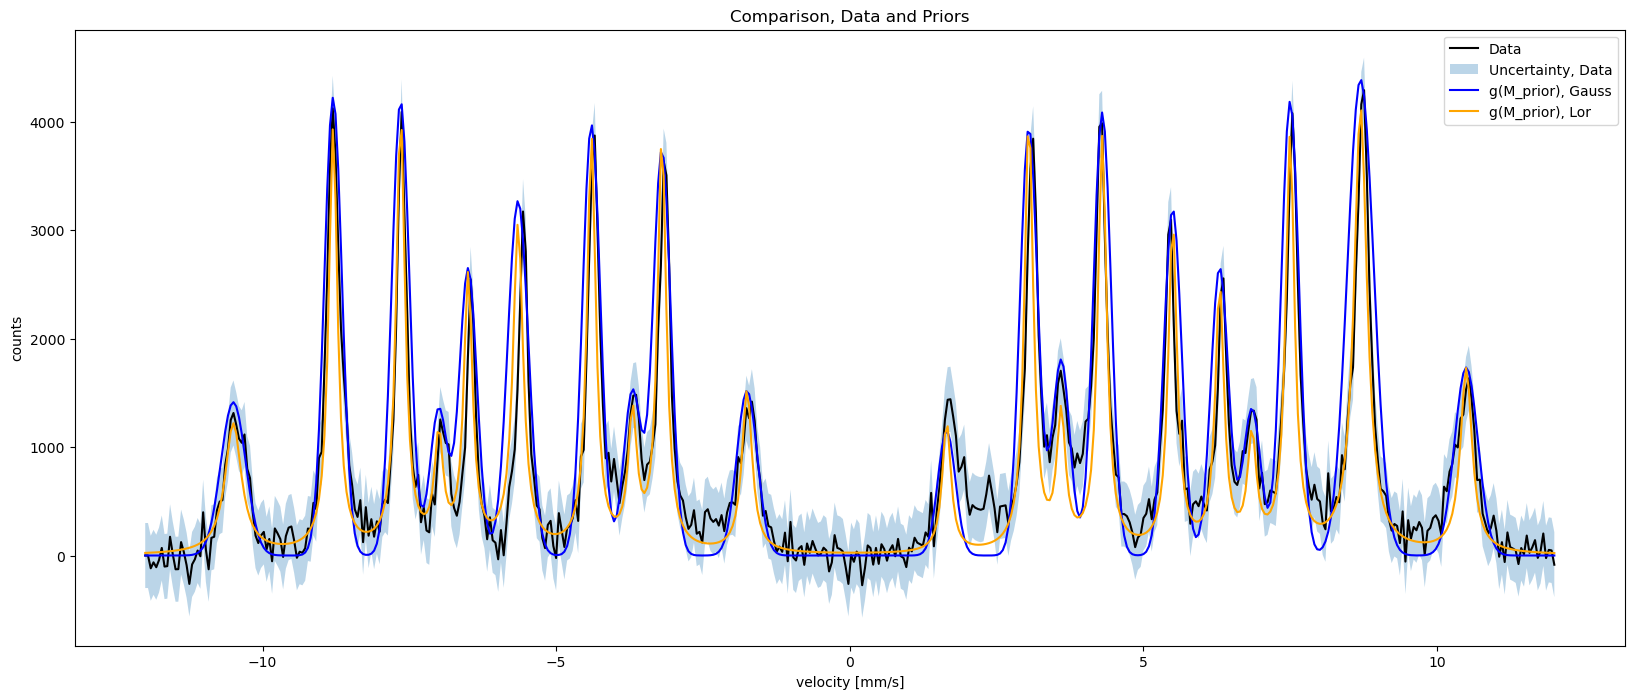

In [22]:
# Plot Both Priors below

plt.figure(figsize = (20,8))
plt.plot(z, ydata, 'k-', label='Data')  # plot data
plt.fill_between(z, ydata - sigma_d, ydata + sigma_d, alpha=0.3, label='Uncertainty, Data') 
plt.plot(z, gauss_, 'b-', markersize='5', label='g(M_prior), Gauss')           
plt.plot(z, lor0, 'orange', linestyle='-', label='g(M_prior), Lor')     
plt.title('Comparison, Data and Priors')
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.legend()



Starting with loop

In [23]:
G = calc_G(prior(A_lor, f_lor, c_lor), z, False)   
test_Cd = calc_Cd(ydata, sigma_d)     
C_d = calc_Cd(ydata, sigma_d)  

s_Ag=s_A0
s_fg=s_f0
s_cg=s_c0 
s_Al=s_A1
s_fl=s_f1
s_cl=s_c1
    
C_m = calc_Cm(prior(A, f, c), True,s_Ag, s_fg, s_cg, s_Al, s_fl, s_cl)


In [24]:
# test run
M_prior = prior(As,fs,cs)
eps = calc_eps(C_m, G, C_d, gauss_, ydata, M_prior, M_prior) 
print('initial value epsilon:', '\n', eps)


initial value epsilon: 
 4.9924901628402934e-08


In [25]:
def run_M(M_init, M_prior_, z_, d_obs_, C_d, gauss, max_N=1000, converge=1e-08):
    M_prior, z, d_obs = M_prior_.copy(), z_.copy(), d_obs_.copy()     

    M_new = M_init.copy()   
    eps_list = []          
    k = 0                   

    total_iterations = max_N
    progress_bar = tqdm(total=total_iterations, desc="Processing")     

    # Run
    while k < max_N:
        upd = update_m(M_new, M_prior, z, d_obs, C_d, gauss)   
        M_new = upd[0]             
        eps_list.append(upd[1])    

        k += 1
        progress_bar.update(1)
        
    return M_new, upd[1], upd[2], k, eps_list


In [26]:
test_run = run_M(prior(A, f, c), prior(A, f, c), z, ydata, C_d, True)

Processing: 100%|███████████████████████████| 1000/1000 [00:29<00:00, 34.37it/s]


**Plot Gaussian Fit**

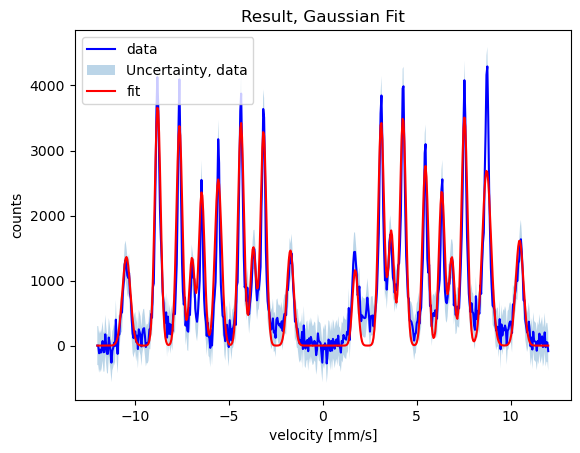

In [27]:
M = test_run[0]

descr1 = unpack(M)
A1, f1, c1 = descr1[0], descr1[1], descr1[2]

fit_gauss = calc_g(M, z, gauss=True)

# plot
plt.figure()
plt.plot(z, ydata, 'b', label='data')       # Data
plt.fill_between(z, ydata - sigma_d, ydata + sigma_d, alpha=0.3, label='Uncertainty, data')
plt.plot(z, fit_gauss, 'r', label='fit')  
plt.title('Result, Gaussian Fit')
plt.legend()
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.show()

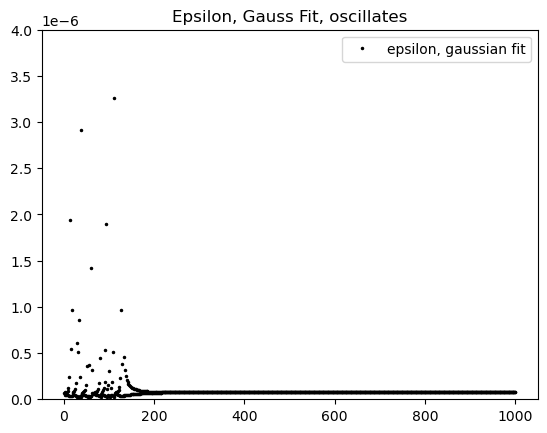

In [28]:
# Check epsilon
np.shape(test_run[-1])

eps1 = test_run[-1]
plt.figure()
plt.plot(np.linspace(1, len(eps1), len(eps1)), eps1, 'k.', markersize=3, label='epsilon, gaussian fit')
plt.title('Epsilon, Gauss Fit, oscillates')
plt.ylim(0, 4e-06)
plt.legend()

**Lorentzian Fit**

In [29]:
result_lor =  run_M(prior(A_lor, f_lor, c_lor), prior(A_lor, f_lor, c_lor), z, ydata, C_d, False)   # False -> Lorentzian Fit

print('epsilon:', result_lor[1])            # last epsilon
print('norm, result - data:', np.linalg.norm(calc_g(result_lor[0], z, gauss=False) - ydata))
np.linalg.norm(result_lor[-2])            # norm  of residual m_k+1 - m_k, is < +1e-07...

Processing: 100%|███████████████████████████| 1000/1000 [00:31<00:00, 31.52it/s]

epsilon: 3.4586444647130987e-07
norm, result - data: 3021.56266034863


1000.0

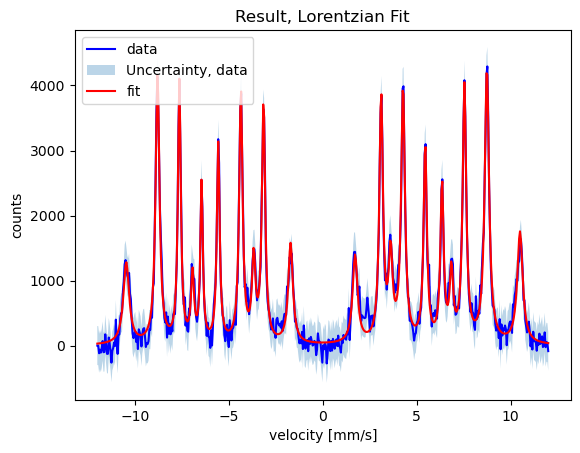

chi sq, Lor: 3.9241587295253355


In [30]:
# Plot Results
M_l = result_lor[0]

descr2 = unpack(M_l)
A2, f2, c2 = descr2[0], descr2[1], descr2[2]
f2[5] = f1[5]
M_l = prior(A2, f2, c2)
# print('f1:', f1)
# print('f2:', f2)

    # Plot Result

fit_lor = calc_g(M_l, z, gauss=False)

# plot
plt.figure()
plt.plot(z, ydata, 'b', label='data')       # Data
plt.fill_between(z, ydata - sigma_d, ydata + sigma_d, alpha=0.3, label='Uncertainty, data')
plt.plot(z, fit_lor, 'r', linestyle='-', label='fit')     

plt.title('Result, Lorentzian Fit')
plt.legend()
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.show()

# Lorentzian Chi square
chi_sq_lor_ = chi_square(ydata, fit_lor, sigma_d)          
print('chi sq, Lor:', chi_sq_lor_)

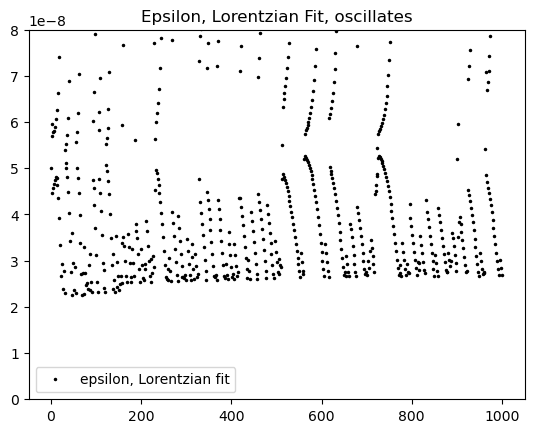

In [31]:
eps2 = result_lor[-1]    
np.shape(eps2)

plt.figure()
plt.plot(np.linspace(1, len(eps2), len(eps2)), eps2, 'k.', markersize=3, label='epsilon, Lorentzian fit')
plt.title('Epsilon, Lorentzian Fit, oscillates')
plt.ylim(0, 8e-8)
plt.legend()

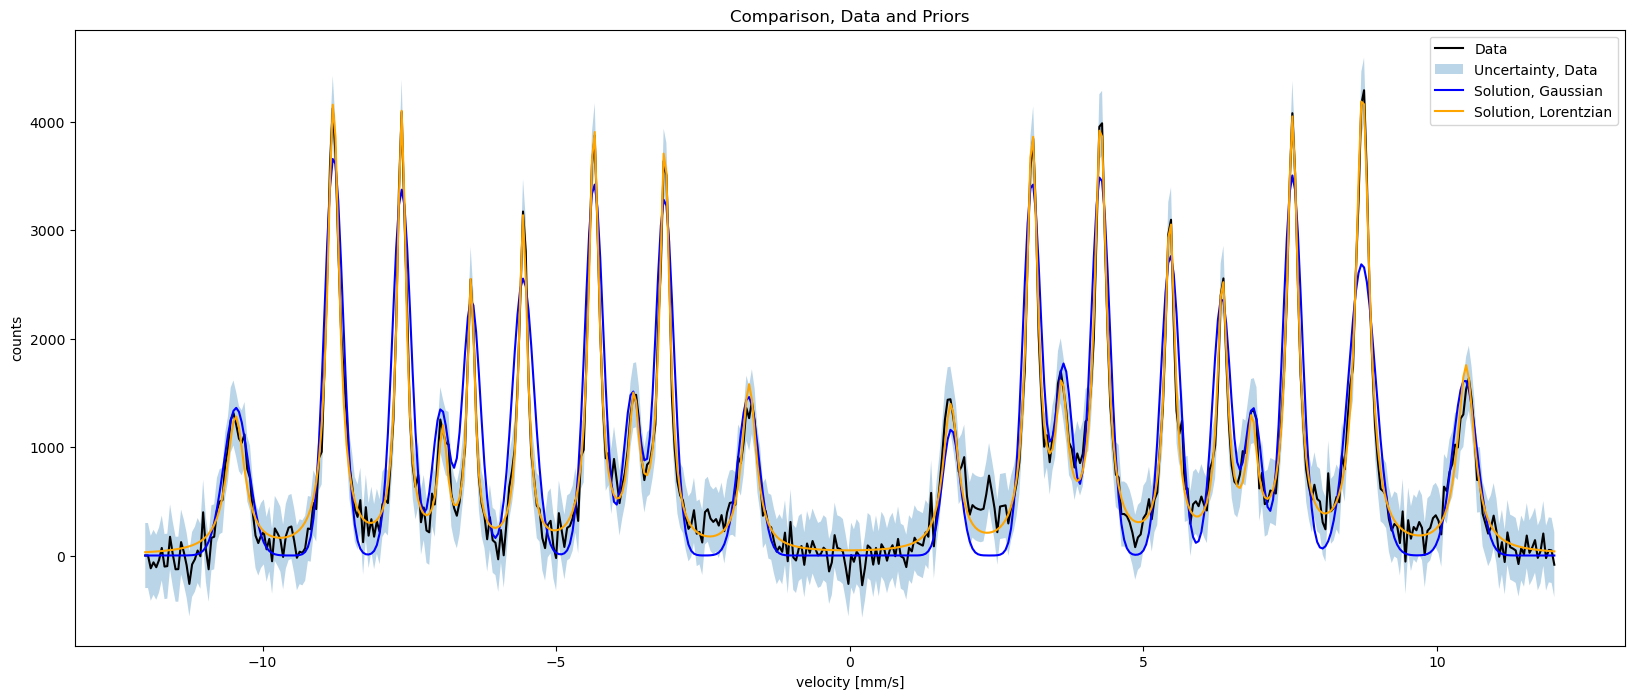

In [32]:
# Final Result

# Plot Fits below
plt.figure(figsize = (20,8))
plt.plot(z, ydata, 'k-', label='Data')  # plot data
plt.fill_between(z, ydata - sigma_d, ydata + sigma_d, alpha=0.3, label='Uncertainty, Data') # uncertainty data
plt.plot(z, fit_gauss, 'b-', markersize='5', label='Solution, Gaussian')    # Fit, Gaussian
plt.plot(z, fit_lor, 'orange', linestyle='-', label='Solution, Lorentzian')      # Fit, Lorentzian
plt.title('Comparison, Data and Priors')
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.legend()


# 4. Question. Results

Tryibng to somewhat judge quantitatively I tried to use the  $\chi^{2}$ values

In [33]:
print("           x^2 values")
print("     ------Posteriori-------")
# gaussian Chi square
chi_sq_gauss = chi_square(ydata, fit_gauss, sigma_d)        

# Lorentzian Chi square
chi_sq_lor = chi_square(ydata, fit_lor, sigma_d)         
print('Gauss:,', chi_sq_gauss, ', Lorentzian:', chi_sq_lor)

print("     ------Prior-------")

# Chi Square, Priors
chi_pr1 = chi_square(ydata, gauss_, sigma_d)            
chi_pr2 = chi_square(ydata, lor0, sigma_d)    
print('Gauss:,', chi_pr1, ', Lorentzian:', chi_pr2)



           x^2 values
     ------Posteriori-------
Gauss:, 6899.217847566544 , Lorentzian: 3.9241587295253355
     ------Prior-------
Gauss:, 69697.79963828469 , Lorentzian: 52052.93218164368


In [34]:
# p-test
# scipy.stats.chi2.sf(chi2 value, NDOF)
ndof = 452    
p1 = scipy.stats.chi2.sf(chi_sq_gauss, ndof)           # estimate p-values
p2 = scipy.stats.chi2.sf(chi_sq_lor, ndof)

print('p1:', p1)
print('p2:', p2)

p1: 0.0
p2: 1.0


the p-values can't be trusted as I would prefer avalue in between 0 and 1 and not 0 or 1. Eitherway, it seems that the Gaussian is far from reality and the lorentzia is too good to be true.

## Lorentzian: Initial and result

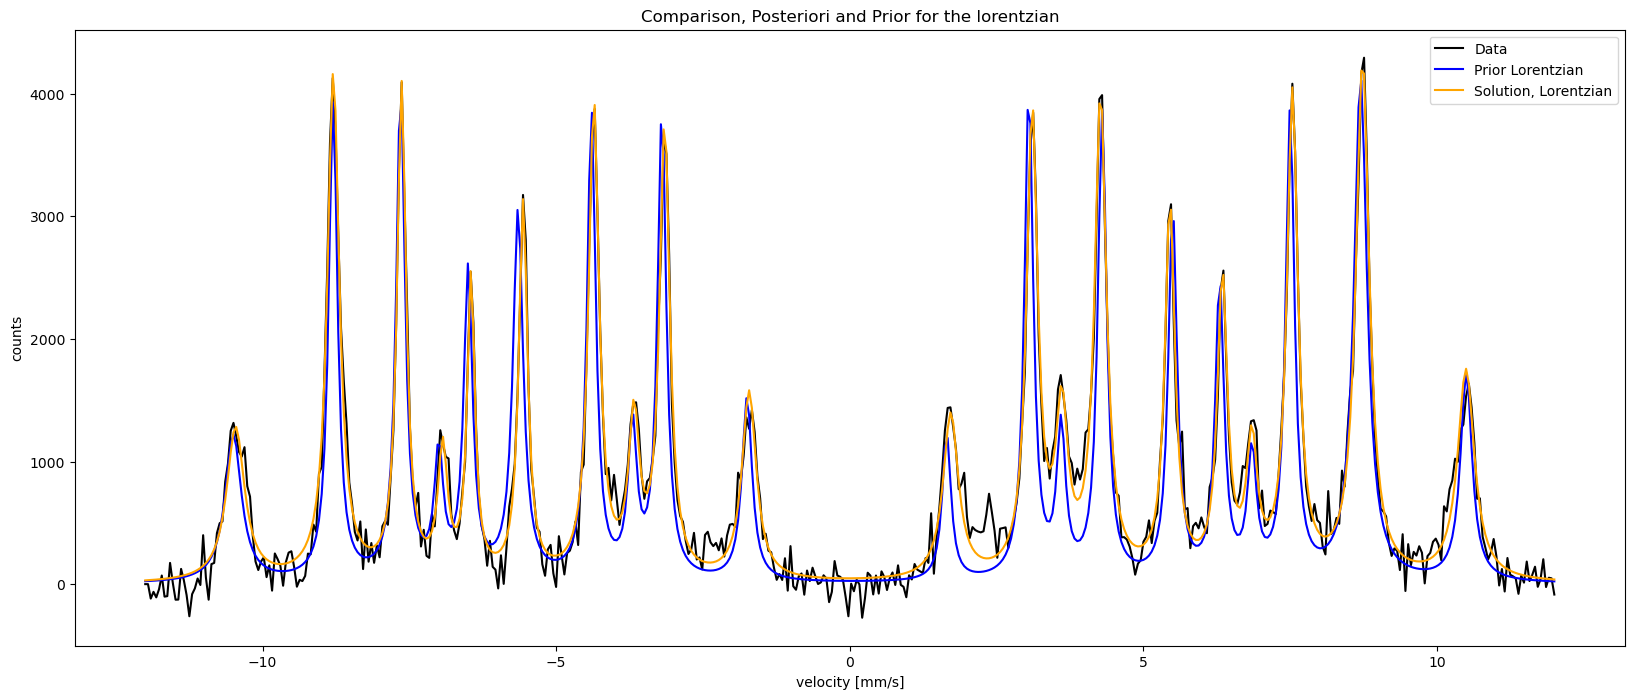

In [35]:
# Lorentzian Fits below
plt.figure(figsize = (20,8))
plt.plot(z, ydata, 'k-', label='Data')  # plot data
plt.plot(z, lor0, 'b-', markersize='5', label='Prior Lorentzian')    
plt.plot(z, fit_lor, 'orange', linestyle='-', label='Solution, Lorentzian')     
plt.title('Comparison, Posteriori and Prior for the lorentzian')
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.legend()


The plot above shows the lorentzian fit before and after the process. It is quite clear that the fitting is much better than the initial one as the top of the points are where the should be and also the valeys seem to be better

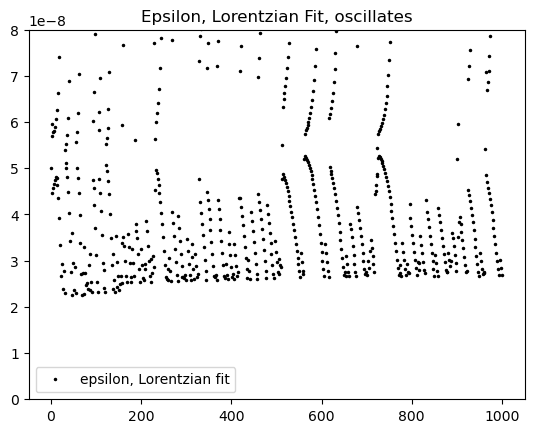

In [36]:
eps2 = result_lor[-1]      # 302 iterations
np.shape(eps2)

plt.figure()
plt.plot(np.linspace(1, len(eps2), len(eps2)), eps2, 'k.', markersize=3, label='epsilon, Lorentzian fit')
plt.title('Epsilon, Lorentzian Fit, oscillates')
plt.ylim(0, 8e-8)
plt.legend()

also, judging from the epsilon it seems that is resonating over a quite small value which seems some kind of conversion. From the other side i would expect in the first steps to have a higher value and as my initial fit was not as good as the solution 

## Gaussian: Initial and result

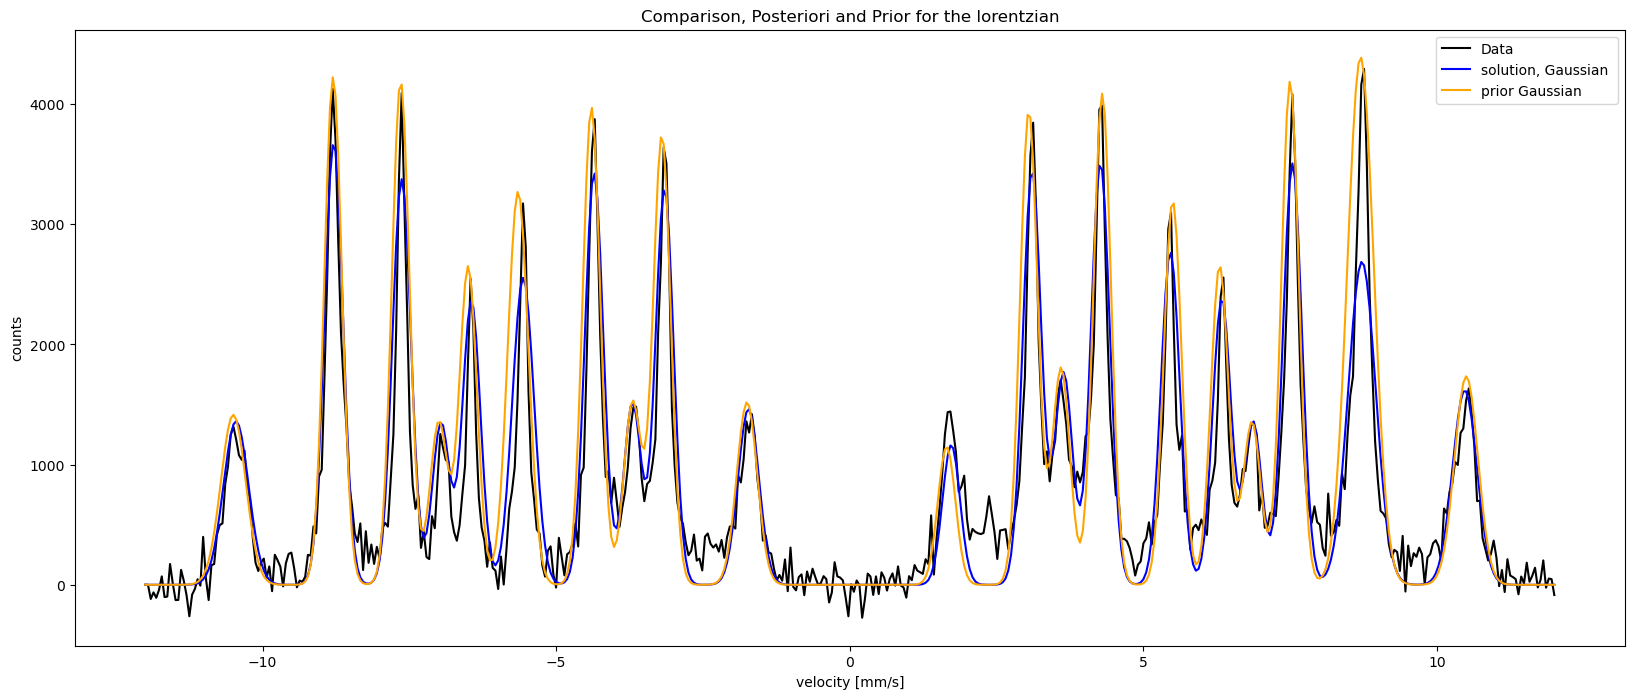

In [37]:
# Lorentzian Fits below
plt.figure(figsize = (20,8))
plt.plot(z, ydata, 'k-', label='Data')  # plot data
plt.plot(z, fit_gauss, 'b-', markersize='5', label='solution, Gaussian ')    
plt.plot(z, gauss_, 'orange', linestyle='-', label='prior Gaussian')     
plt.title('Comparison, Posteriori and Prior for the lorentzian')
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.legend()


In that case it seems that the gaussian turns to be get worse and worse even though i tried more than 10000 iterations

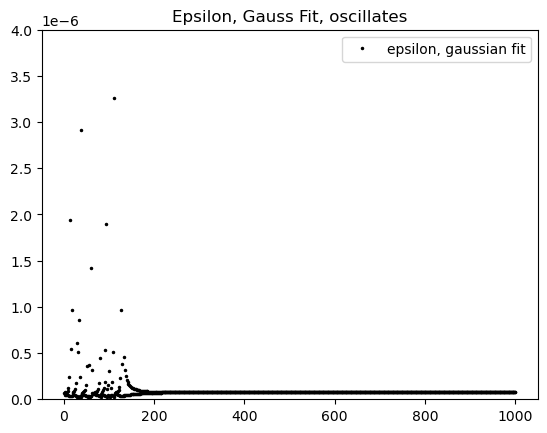

In [38]:
# Check epsilon
np.shape(test_run[-1])

eps1 = test_run[-1]
plt.figure()
plt.plot(np.linspace(1, len(eps1), len(eps1)), eps1, 'k.', markersize=3, label='epsilon, gaussian fit')
plt.title('Epsilon, Gauss Fit, oscillates')
plt.ylim(0, 4e-06)
plt.legend()

This epsilon looks more to something that I would predict, a value converging towards a value starting from high. As I mentioned earlier the gaussian initial fit was abit worse than the gaussians so this could explain the high values of epsilon at the first steps

## Combined results

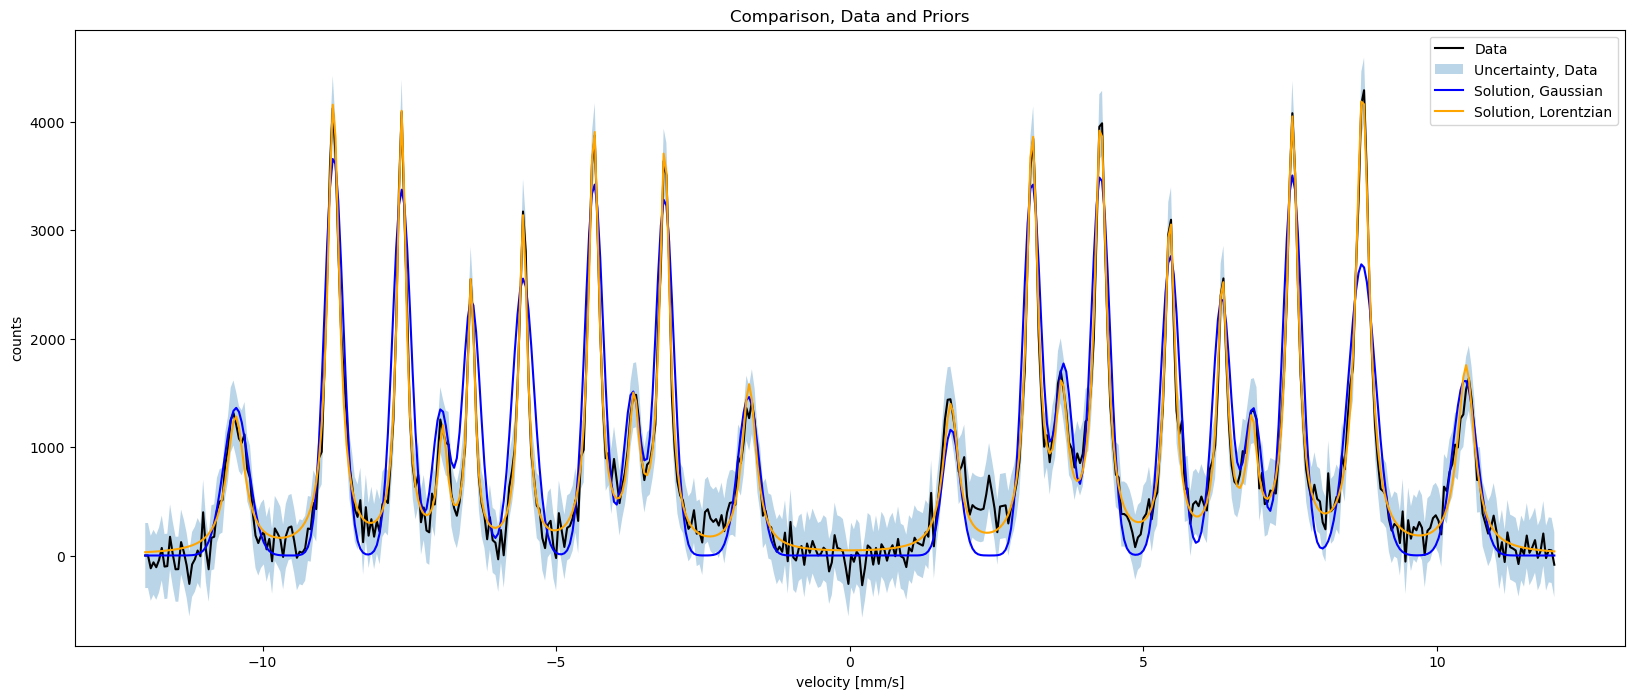

In [39]:
# Final Result

# Plot Fits below
plt.figure(figsize = (20,8))
plt.plot(z, ydata, 'k-', label='Data')  # plot data
plt.fill_between(z, ydata - sigma_d, ydata + sigma_d, alpha=0.3, label='Uncertainty, Data') 
plt.plot(z, fit_gauss, 'b-', markersize='5', label='Solution, Gaussian')    
plt.plot(z, fit_lor, 'orange', linestyle='-', label='Solution, Lorentzian')     
plt.title('Comparison, Data and Priors')
plt.xlabel('velocity [mm/s]')
plt.ylabel('counts')
plt.legend()

To conclude, judging from the plot above which includes the results for the lorentzian and the Gaussian model, it seems that the lorentzian fits our data much better even though the initial fit seemed to beet for the gaussian.